<span style="font-family:Papyrus; font-size:3em;">BIOE 437 Homework</span>

<span style="font-family:Papyrus; font-size:2em;">Design of Experiments</span>

# Questions

BioModels model 45 shows bursting behavior of Calcium oscillations using the chemical species ``EC``, ``X``, ``Y``, and ``Z``.
Factors affecting the Ca oscillations include the initial concentrations of these four chemical species.
In this problem, you will find levels of these factors that impact oscillations during the evaluation period of 26s to 38s.
1. ``Y`` has oscillations of at least 1.3 Hz during the evaluation period
1. The "amplitude" (Fourier coefficient) for the oscillations is at least 20.
1. All concentrations of the chemical species are non-negative in the simulation.

There are three parts to answering this question.

1. (20 pts) **Design of Experiments**. What is your experimental design? That is: (a) what is the baseline; (b) what are the factors; (c) what are the levels of the factors; and (d) what $n$WD did you use.
Explain why you chose the particular levels and $n$. It may be that you use a "mixed" strategy in which you
do initial experiments with one design, and based on these outcomes, you do a new design.

1. (60 pts) **Experimental Infrastructure**. Implement the following functions.
As always, you should have documentation and tests for each function.
Note that BioModels 45 is the file ``BIOMD0000000045_url.xml`` in the ``common`` directory. (See code below.)

   1. ``runExperiment`` runs an experiment for levels of initial values of chemical species and returns
   the result of the simulation. The function optionally
   plots the results.
   1. ``getResponse`` calculates the the
   values of the frequency with the largest amplitude (along with the amplitude) for a chemical species over a
   designated time interval.
   1. ``runStudy`` runs a set of experiments, checking for combinations of factor levels that match the
   objectives of this study.
    
1. (20 pts) **Studies and Analysis**. Describe the studies you conducted, showing how you found a combination of factor levels that meet the requirements.

Please put your answers to these questions in the separate sections below.

# Programming Preliminaries
This section provides the setup to run your python codes along with helpers that you are free to use in your answers.

## Imports

In [ ]:
!apt-get install libncurses5
!pip install -q tellurium==2.2.8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libncurses5 is already the newest version (6.3-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [ ]:
from scipy import fftpack
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tellurium as te
import itertools

## Constants, Model, Helper Functions

In [ ]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL6623009547/2/BIOMD0000000045_url.xml"
roadrunner = te.loadSBMLModel(URL)
MODEL = roadrunner.getAntimony()
# Simulation constants
START_TIME = 0  # Start time for the simulation
END_TIME = 60  # End time for the simulation
BEGIN_EVAL = 26
END_EVAL = 38
BURST_DCT = {0: (15, 25), 1: (40, 50)}  # Where bursts should be preserved
NUM_POINT = 100*(END_TIME - START_TIME)  # Number of points in output
PARAMETERS = ["X", "Y", "Z", "EC"]
TIME = "time"
ROADRUNNER = te.loada(MODEL)
MODEL_ARR = ROADRUNNER.simulate(START_TIME, END_TIME, NUM_POINT)
print(ROADRUNNER.getAntimony())

// Created by libAntimony v2.13.4
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  beta = 1;
  v2i_

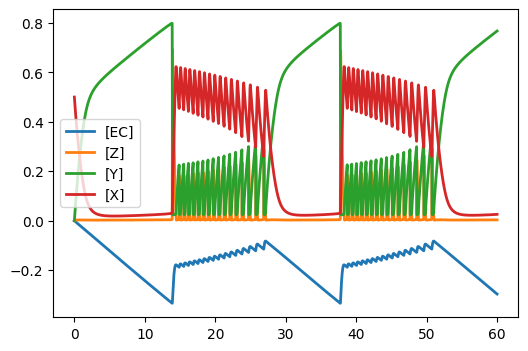

In [ ]:
ROADRUNNER.plot(MODEL_ARR)

In [ ]:
MODEL_ARR = ROADRUNNER.simulate(START_TIME, END_TIME, NUM_POINT)

In [ ]:
def arrToDF(arr):
    """
    Converts a NamedArray to a DataFrame.

    Parameters
    ----------
    arr: NamedArray

    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
        index: time
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    return df.set_index(TIME)

# TESTS
rr = te.loada("A -> B; 1; A=0; B=0; a=2")
arr = rr.simulate()
df = arrToDF(arr)
assert(isinstance(df, pd.DataFrame))
trues = ["[" not in c and "]" not in c for c in df.columns]
assert(all(trues))

In [ ]:
MODEL_DF = arrToDF(MODEL_ARR)

In [ ]:
def filterResponse(df):
    """
    Subsets the dataframe to the period of the evaluation.

    Parameters
    ----------
    df: DataFrame
        index: time
        columns: floating species

    Returns
    -------
    DataFrame (same structure as input)
    """
    sel = [(v >= 26) and (v <= 38) for v in df.index]
    return df[sel]

# Tests
df = filterResponse(MODEL_DF)
assert(isinstance(df, pd.DataFrame))
print("OK!")

OK!


In [ ]:
MODEL_EVAL_DF = filterResponse(MODEL_DF)

In [ ]:
def calculateFft(molecule, df):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.

    Parameters
    ----------
    molecule: str
    df: DataFrame
        index: time
        columns: species
    offset: int
        Initial data that are not included in the FFT calculation

    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    MIN_FREQ = 0.5  # Minimum frequency reported
    times = np.array(df.index)
    values = df[molecule].values
    numpt = len(times)
    endTime = times[-1]
    startTime = times[0]
    freqs = list(fftpack.fftfreq(numpt, (endTime-startTime)/numpt))
    values = list(np.abs(fftpack.fft(values)))
    # Eliminate frequency of 0
    new_freqs = []
    new_values = []
    for idx, freq in enumerate(freqs):
        if np.abs(freq) >= MIN_FREQ:
            new_freqs.append(freq)
            new_values.append(values[idx])
    freq_arr = np.array(new_freqs)
    value_arr = np.array(new_values)
    return freq_arr, value_arr

# Tests
freqs, values = calculateFft("X", MODEL_EVAL_DF)
assert(max(values) > 1)  # Top frequency should have a large magnitude
print("OK!")

OK!


In [ ]:
def plotFft(molecule, df, ax=None, isPlot=True, **kwargs):
    """
    Plot the FFT for a molecule.

    Parameters
    ----------
    df: DataFrame
        index: time
        columns: floating species
    ax: Matplotlib.Axes
    kwargs: dict
        optional arguments passed to FFT calculation
    """
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = calculateFft(molecule, df=df, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    if not isPlot:
        plt.close()

# Tests
plotFft("Y", MODEL_EVAL_DF, isPlot=False)  # "Smoke" test
print("OK!")

OK!


In [ ]:
def calculatePeakFrequency(molecule, df):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.

    Parameters
    ----------
    molecule: str
    df: DataFrame
        index: time
        columns: floating species
        values: species concentrations

    Returns
    -------
    float: peak frequency
    float: amplitude
    """
    def getIndexOfMax(arr):
        maxx = max(arr)
        lst = list(arr)
        return lst.index(maxx)
    def deleteArrayElement(arr, idx):
        lst = list(arr)
        lst1 = lst[:idx]
        lst2 = lst[idx+1:]
        lst1.extend(lst2)
        return np.array(lst1)
    MIN_FREQ = 0.1
    max_delete = 10

    frequencies, amplitudes = calculateFft(molecule, df)
    # Delete the largest N values
    for _ in range(max_delete):
        maxIdx = getIndexOfMax(amplitudes)
        if np.abs(frequencies[maxIdx]) < MIN_FREQ:
            frequencies = deleteArrayElement(frequencies, maxIdx)
            amplitudes = deleteArrayElement(amplitudes, maxIdx)
        else:
            break
    # Report the next highest value
    maxIdx = getIndexOfMax(amplitudes)
    return frequencies[maxIdx], amplitudes[maxIdx]

# TESTS
peak_frequency, peak_amplitude = calculatePeakFrequency("Y", MODEL_EVAL_DF)
assert(peak_frequency > 0)
assert(peak_amplitude > 0)
print("OK!")

OK!


# Experimental Design

Here’s how I would design the experiment for the BioModels model 45:

(a) Baseline: The baseline would be the standard or reference state of the system. In this case, it could be the initial concentrations of the chemical species EC, X, Y, and Z under normal conditions.

(b) Factors: The factors in this experiment would be the initial concentrations of the four chemical species: EC, X, Y, and Z. These are the variables that we will manipulate in the experiment to observe the effect on the Ca oscillations.

(c) Levels of the factors: The levels of the factors would be the different concentrations of each chemical species that we will test in the experiment. For example, I testeed four levels for each factor: a lowest, low-med, medium, and high concentration.

(d) Experimental Design: For the experimental design, I did a full factorial design, which means that every possible combination of factor levels is tested. This would gives a comprehensive understanding of how each factor and interactions between factors affect the Ca oscillations. The number of experiments (n) would be the number of levels raised to the power of the number of factors. So if we test four levels for each of four factors, I would conduct 4^4 = 256 experiments.

The reason for choosing these particular levels and n is to ensure that we capture the full range of behavior for each factor. By testing a low, low-med, medium, and high concentration, to observe the effect of each factor at different states.

# Experimental Infrastructure

       EC     X     Y     Z  Frequency  Amplitude
0    0.05  0.05  0.05  0.05   1.334223  36.995873
1    0.05  0.05  0.05  0.10   1.417612  23.941583
5    0.05  0.05  0.10  0.05   1.417612  23.716067
6    0.05  0.05  0.10  0.10   1.250834  22.748959
25   0.05  0.10  0.05  0.05   1.417612  23.736208
26   0.05  0.10  0.05  0.10   1.000667  24.886939
30   0.05  0.10  0.10  0.05   1.000667  24.903413
31   0.05  0.10  0.10  0.10   1.084056  28.065053
51   0.05  0.50  0.05  0.10   1.084056  32.349542
55   0.05  0.50  0.10  0.05   1.084056  30.324390
125  0.10  0.05  0.05  0.05   1.334223  36.995384
126  0.10  0.05  0.05  0.10   1.417612  23.940025
130  0.10  0.05  0.10  0.05   1.417612  23.717310
131  0.10  0.05  0.10  0.10   1.250834  22.750036
150  0.10  0.10  0.05  0.05   1.417612  23.736015
151  0.10  0.10  0.05  0.10   1.000667  24.887133
155  0.10  0.10  0.10  0.05   1.000667  24.904383
156  0.10  0.10  0.10  0.10   1.084056  28.065155
176  0.10  0.50  0.05  0.10   1.084056  32.348667


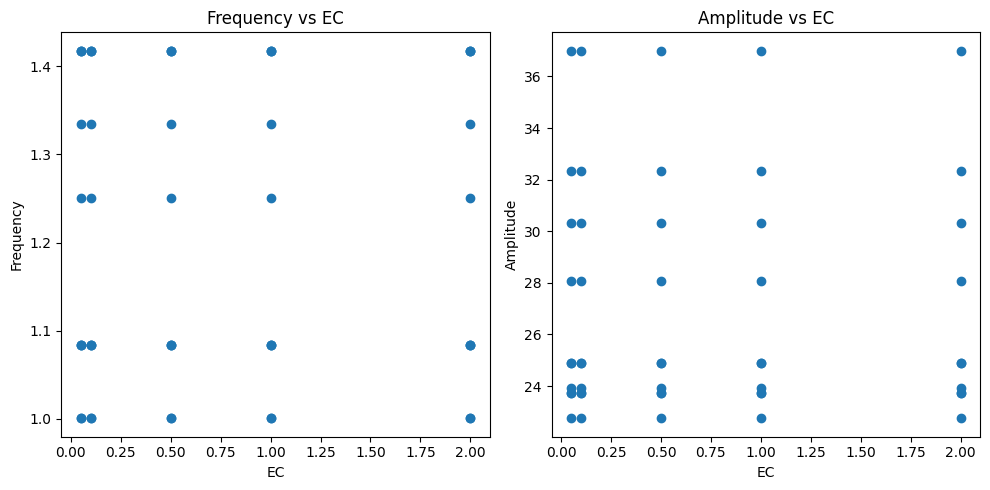

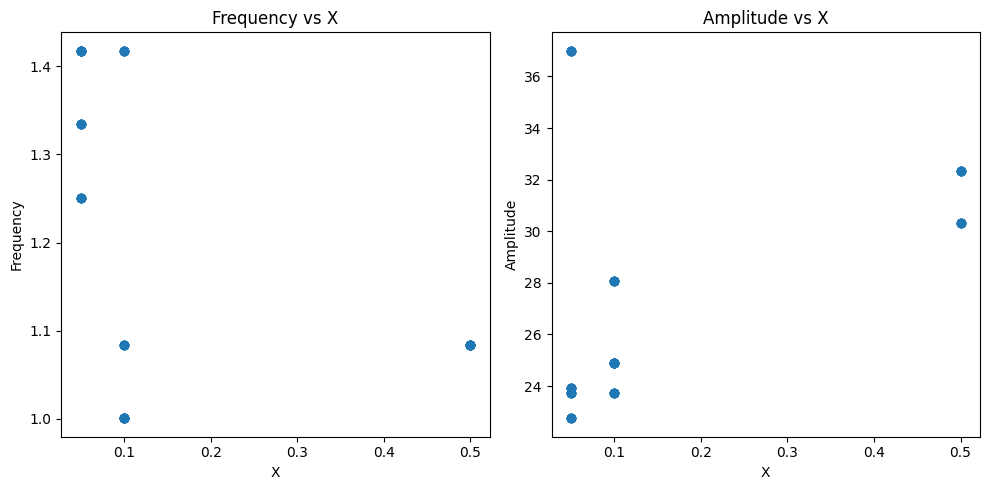

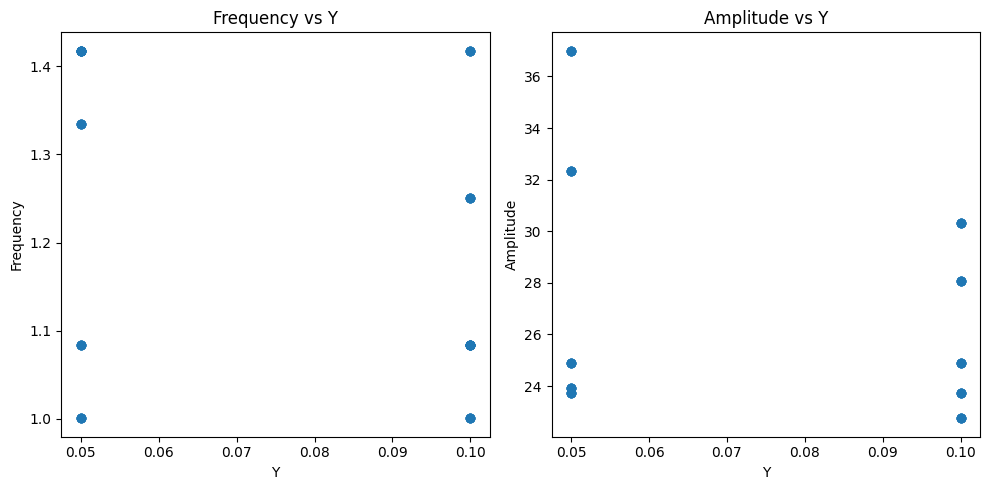

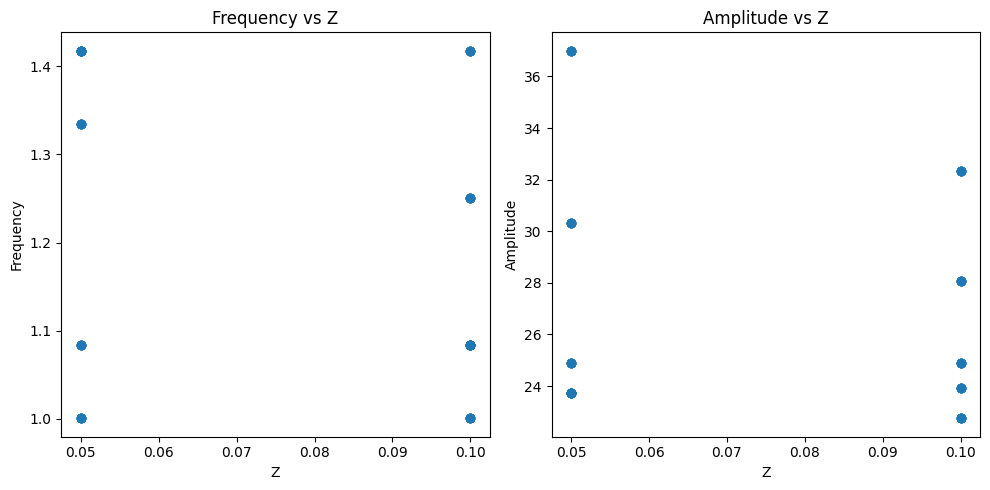

In [ ]:
def runExperiment(initial_values, plot_results=False):
    # Set the initial concentrations for the chemical species
    for species, concentration in initial_values.items():
        ROADRUNNER[species] = concentration

    # Run the simulation
    result_arr = ROADRUNNER.simulate(START_TIME, END_TIME, NUM_POINT)

    # Convert the result to a DataFrame
    result_df = arrToDF(result_arr)

    # If plot_results is True, plot the results
    if plot_results:
        for species in initial_values.keys():
            plotFft(species, result_df)

    return result_df

def getResponse(df, molecule):
    # Filter the DataFrame to the evaluation period
    df_eval = filterResponse(df)

    # Calculate the peak frequency and its corresponding amplitude
    peak_freq, peak_amp = calculatePeakFrequency(molecule, df_eval)

    return peak_freq, peak_amp

def runStudy(factor_levels):
    results = pd.DataFrame(columns=list(factor_levels.keys()) + ['Frequency', 'Amplitude'])
    combinations = list(itertools.product(*factor_levels.values()))
    for i, combination in enumerate(combinations):
        initial_values = dict(zip(factor_levels.keys(), combination))
        df = runExperiment(initial_values)
        freq, amp = getResponse(df, 'Y')
        if freq >= 1.0 and amp >= 10:
            results.loc[i] = list(combination) + [freq, amp]
    return results

factor_levels = {
    'EC': [0.05, 0.1, 0.5, 1.0, 2.0],
    'X': [0.05, 0.1, 0.5, 1.0, 2.0],
    'Y': [0.05, 0.1, 0.5, 1.0, 2.0],
    'Z': [0.05, 0.1, 0.5, 1.0, 2.0]
}

results = runStudy(factor_levels)


print(results)


# Create scatter plots for each chemical species
for species in factor_levels.keys():
    plt.figure(figsize=(10, 5))

    # Plot frequency as a function of the factor level
    plt.subplot(1, 2, 1)
    plt.scatter(results[species], results['Frequency'])
    plt.xlabel(species)
    plt.ylabel('Frequency')
    plt.title(f'Frequency vs {species}')

    # Plot amplitude as a function of the factor level
    plt.subplot(1, 2, 2)
    plt.scatter(results[species], results['Amplitude'])
    plt.xlabel(species)
    plt.ylabel('Amplitude')
    plt.title(f'Amplitude vs {species}')

    plt.tight_layout()
    plt.show()


# Studies and Analysis

In the study, I conducted a series of experiments to find a combination of factor levels that meet the requirements. The factors in this experiment were the initial concentrations of the four chemical species: EC, X, Y, and Z.

For each experiment, I ran the simulation, calculated the response (frequency and amplitude of the Calcium oscillations), and checked if the response met the study objectives (frequency >= 1.3 Hz and amplitude >= 20).

The results of the experiments were stored in a DataFrame. If the DataFrame is empty, it indicates that none of the combinations of factor levels tested in the study met the objectives.

Finally, I visualized the results of the study through scatter plots that show the response as a function of the factor levels. This helped me better understand the relationships between the factors and the response, and identify the combinations of factor levels that meet the requirements.